### CONFIG:

In [1]:
from utils.custom_enums import Model_Type_Enum, Dataset_Type_Enum, TRAK_Type_Enum
model_type = Model_Type_Enum.LORA
dataset_type = Dataset_Type_Enum.CIFAR10
TRAK_type = TRAK_Type_Enum.TRAK

#TRAK CIFAR10 LORA 10min iirc? (with cuda obvs)

SWAP_DATASETS = False

UPDATE_SCORES = False

CALCULATE_LDS = True

from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config
from LDS.LDS_Utils import LDS
from TRAK.TRAK_utils import TRAK_Experiment_Config

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

trak_config = TRAK_Experiment_Config(
    project_config=project_config,
    model_type=model_type,
    TRAK_type=TRAK_type,
    dataset_type=dataset_type,
    FORCE_FULL_MODEL_TEST_DATASET=SWAP_DATASETS
    )

model_config = trak_config.model_config

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  "generated-" + dataset_type + f +
                  trak_config.MODEL_NAME_CLEAN)

if dataset_type == Dataset_Type_Enum.CIFAR10:
    train_dataset_config = CIFAR_10_Config()
if dataset_type == Dataset_Type_Enum.CIFAR2:
    train_dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )

generated_dataset_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


TRAK is being saved to /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/TRAK_sd1-lora


### Imports:

In [2]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

In [3]:
traker, tokenizer, text_encoder, vae, unet, ckpts = trak_config.load_TRAKer(len(train_dataset_config.dataset))

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:STORE:Existing model IDs in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/TRAK_sd1-lora: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Existing TRAK scores:
INFO:STORE:sd1-lora_normal_test_dataset: /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/results/cifar10/TRAK_sd1-lora/scores/sd1-lora_normal_test_dataset.mmap


Model contains 797184 trainable parameters


Dataset({
    features: ['image', 'label_txt'],
    num_rows: 50000
})
Dataset({
    features: ['image', 'label_txt'],
    num_rows: 200
})


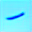

In [4]:
train_dataset = train_dataset_config.preprocess(tokenizer)
print(train_dataset)
generated_dataset = generated_dataset_config.preprocess(tokenizer)
print(generated_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=train_dataset_config.collate_fn,
    batch_size=1,
)

# DataLoaders creation:
generated_dataloader = DataLoader(
    generated_dataset,
    shuffle=False,
    collate_fn=generated_dataset_config.collate_fn,
    batch_size=1,
)

train_dataset_config.dataset[6]['image']
train_dataset[6]["image"]
generated_dataset_config.dataset[6]['image']
generated_dataset[6]["image"]

In [5]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
weight_dtype = torch.float32

if UPDATE_SCORES:
    for model_id, ckpt in enumerate(tqdm(ckpts)):
        if trak_config.model_type == Model_Type_Enum.LORA:
            p = trak_config.model_config.getModelDirectory()
            #TODO: fix the horrid local/global unet duplication going on here
            unet = model_config.loadLoRAUnet(p,ckpt)
            ckpt_local = unet.state_dict()
        else:
            ckpt_local = ckpt

        traker.start_scoring_checkpoint(exp_name=trak_config.EXPERIMENT_NAME,

                                            checkpoint=ckpt_local,

                                            model_id=model_id,

                                            num_targets=len(generated_dataloader))
        

        for batch in tqdm(generated_dataloader):
                if project_config.IS_CUDA:
                    batch = [x.cuda() for y,x in batch.items()]
                else:
                    batch = [x for y,x in batch.items()]
                image = batch[0]
                tokens = batch[1]
                # Convert images to latent space
                latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

                batch = [latents, encoder_hidden_states]
                traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name=trak_config.EXPERIMENT_NAME)

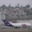

In [7]:
train_dataset[0]["image"]

MOF Scores
[0.27053106 0.27518904 0.27268156 0.28873965 0.28497124 0.27339062
 0.26312438 0.2690205  0.28159025 0.25799477 0.25689471 0.25789875
 0.24923858 0.27476853 0.30666071 0.27055249 0.28470361 0.27699009
 0.26766109 0.267225   0.27441263 0.2654449  0.27502775 0.27997574
 0.27629516 0.26269981 0.26501301 0.28900403 0.29002774 0.26748213
 0.28851834]
g_scores
[ 0.00549668 -0.01687533 -0.00095272 -0.02320212 -0.04896623 -0.04624778
  0.00260204 -0.08454996 -0.05167413  0.02022982 -0.06038254 -0.00665718
 -0.01045173  0.00480074 -0.0176729  -0.03787792 -0.02380067  0.01620811
 -0.08040786 -0.0114243  -0.06099504 -0.01526004 -0.08564085 -0.0153783
 -0.05554169 -0.07337254 -0.00584745  0.01752186 -0.00797158 -0.04815364
 -0.00258148]
spearman_rank_scores
[ 0.00806452 -0.06895161 -0.1391129  -0.13548387 -0.39637097 -0.02016129
 -0.01169355 -0.35201613  0.06290323 -0.08185484 -0.15645161 -0.11330645
  0.04596774  0.01169355 -0.21048387 -0.00645161 -0.05040323 -0.08225806
 -0.00564516 -

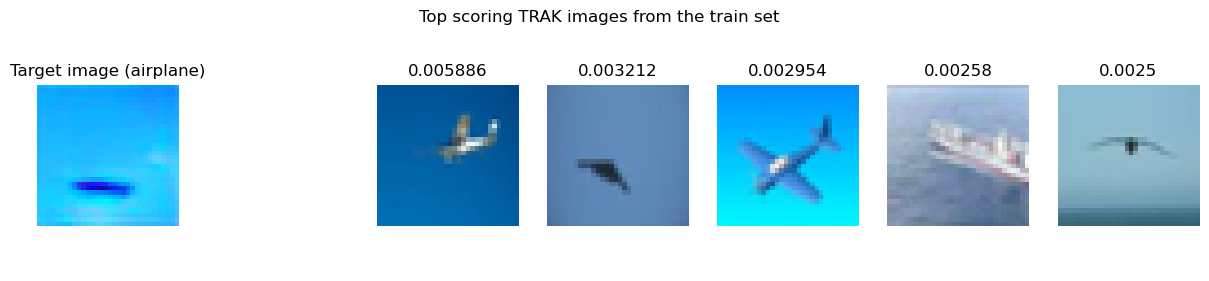

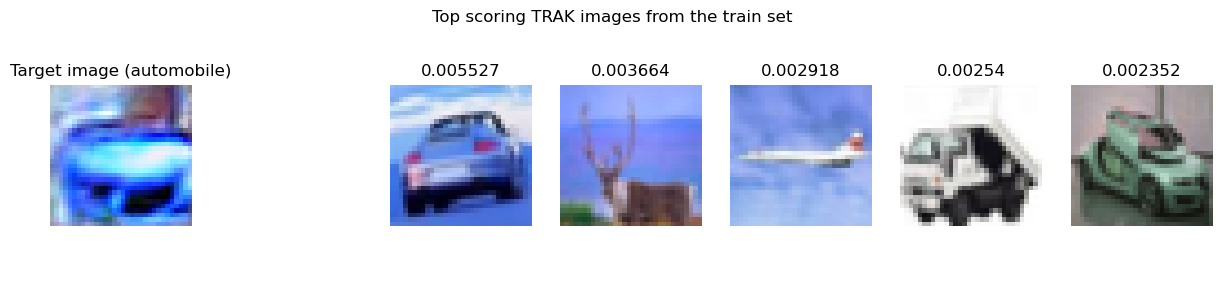

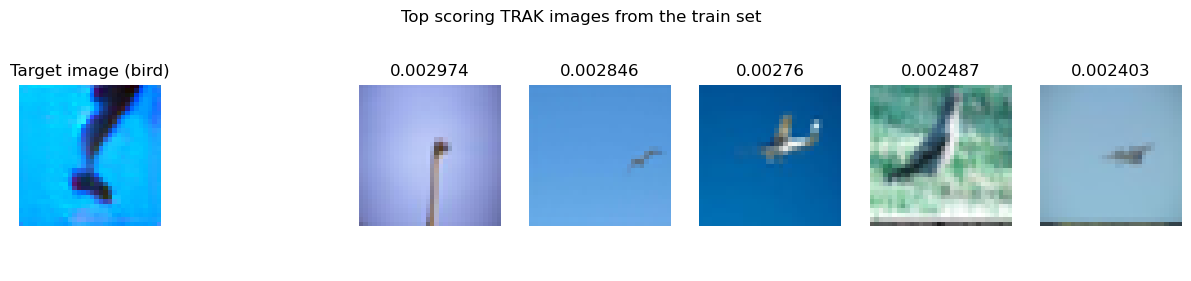

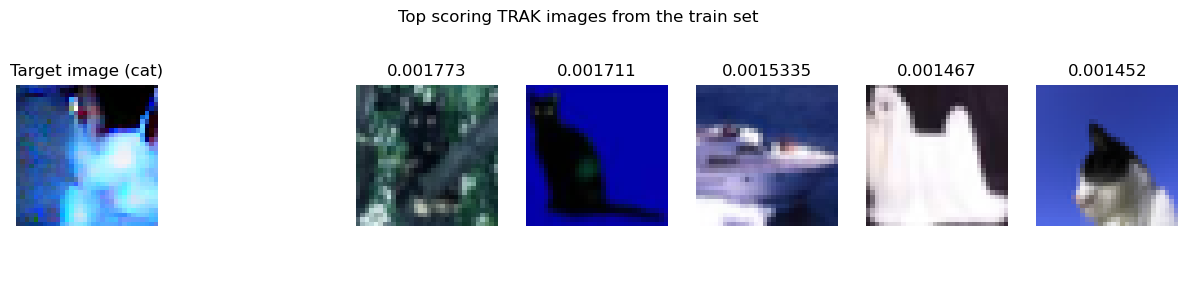

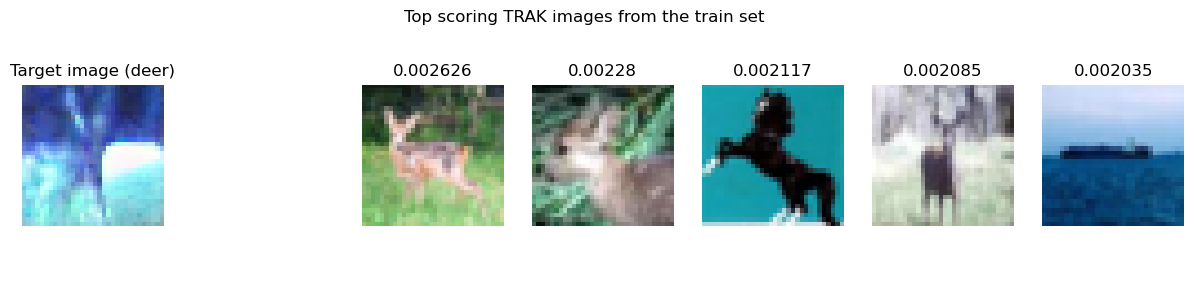

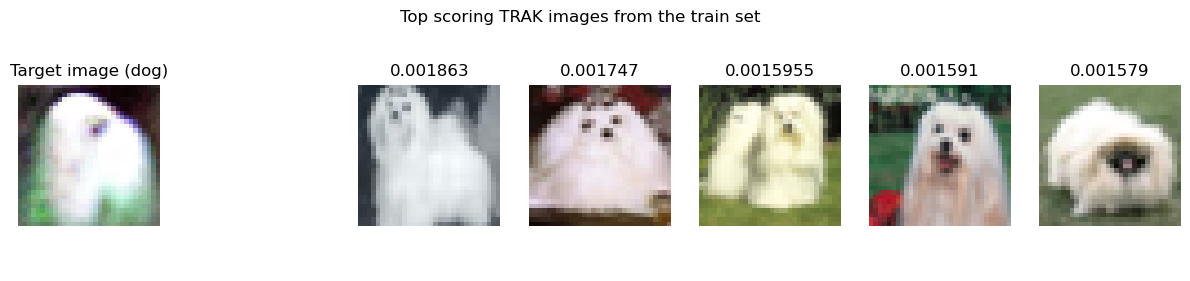

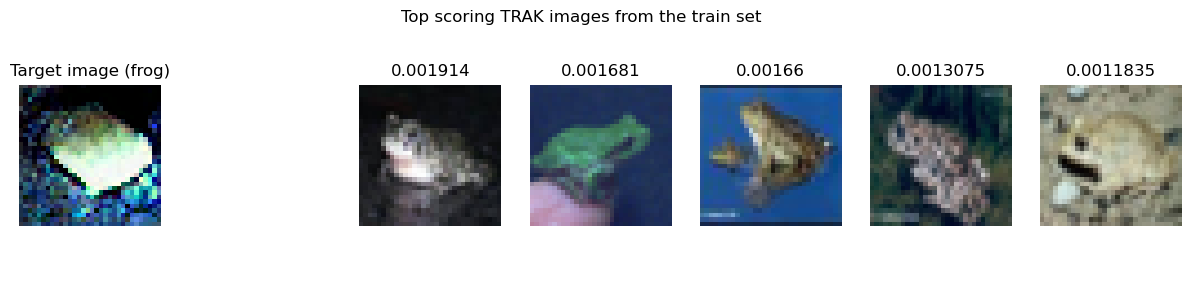

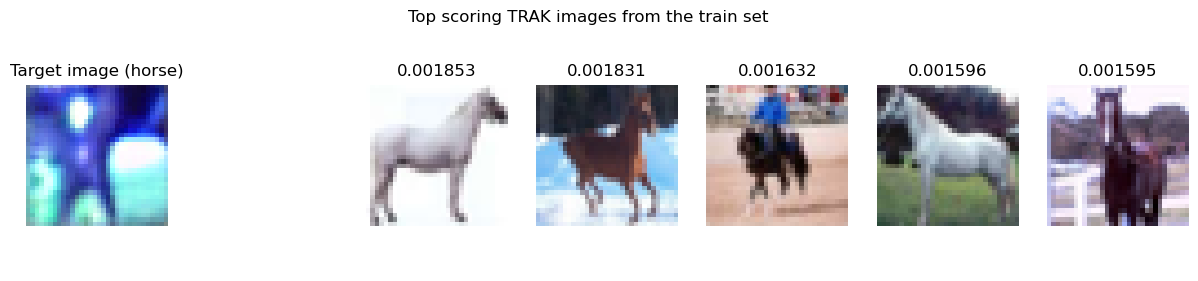

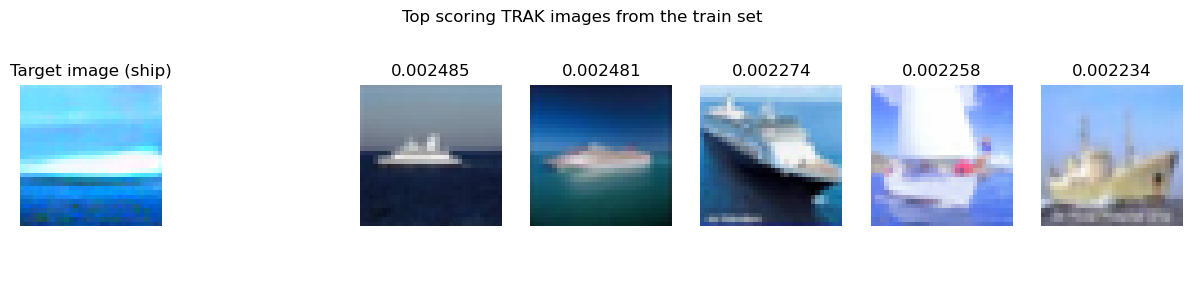

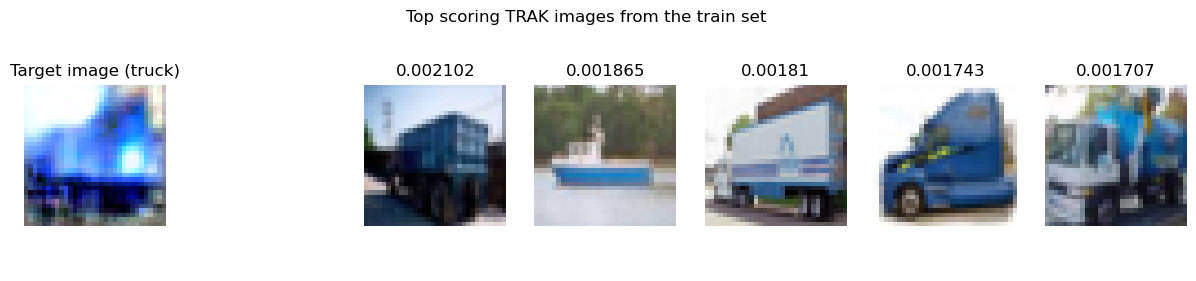

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

scores = trak_config.load_scores()

#print(scores.shape)

#scores = scores*0
#Scale the scores s.t. min is 0 and the sum is 1
#for i in range(10):
#    if scores[:,i].min() < 0:
#        scores[:,i] -= scores[:,i].min()
#    scores[:,i] *= (1/scores[:,i].sum())

if CALCULATE_LDS:
    lds_score = LDS(project_config=project_config,
        training_dataset_config=train_dataset_config,
        generated_dataset_dataloader=generated_dataloader,
        training_dataset_type=dataset_type,
        generated_dataset_size=len(generated_dataset_config.dataset),
        attribution_scores_tau=scores,
        seed=42
    )
    print(f"LDS: {lds_score*100}%")

NUM_SEEDS = 20
SEED_TO_PREVIEW = 1
NUM_CLASSES = len(generated_dataset_config.class_captions)
for i in range(SEED_TO_PREVIEW,NUM_CLASSES*NUM_SEEDS,NUM_SEEDS):

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(generated_dataset[i][generated_dataset_config.image_column])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + generated_dataset[i][generated_dataset_config.caption_column] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)][generated_dataset_config.image_column])
        axs[ii + 2].axis('off')
        axs[ii + 2].set_title(str(scores[int(train_im_ind),i]))

    fig.show()

In [9]:
from utils.dataset_utils import Dataset_Generator
dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type,)

cfds = Dataset_Generator(
    project_config=project_config,
    dataset_type=dataset_type,
    dataset_config=dataset_config,
)

ValueError: Config name is missing.
Please pick one among the available configs: ['full', 'DINO_sd1-full_frog_seed_1', 'DINO_sd1-lora_frog_seed_1', 'TRAK_sd1-lora_frog_seed_1']
Example of usage:
	`load_dataset('cifar10', 'full')`

In [ ]:
prompts = train_dataset_config.class_captions

In [ ]:
#I'm having exactly none of numpy's memmap BS today
scores_c = np.copy(scores)

TARGET_CLASS: horse
TARGET_SEED: 1
TARGET_IMAGE: 1


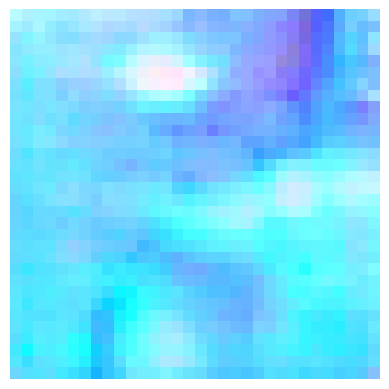

In [ ]:
if dataset_type == Dataset_Type_Enum.CIFAR10:
    TARGET_CLASS = "frog"
if dataset_type == Dataset_Type_Enum.CIFAR2:
    TARGET_CLASS = "horse"
    
assert(TARGET_CLASS in prompts)
print(f"TARGET_CLASS: {TARGET_CLASS}")
print(f"TARGET_SEED: {SEED_TO_PREVIEW}")

TARGET_IMAGE = prompts.index(TARGET_CLASS) #Seed 1, frog
print(f"TARGET_IMAGE: {TARGET_IMAGE}")
plt.axis('off')
i = SEED_TO_PREVIEW+(TARGET_IMAGE*NUM_SEEDS)
plt.imshow(generated_dataset[i][generated_dataset_config.image_column])

top_trak_scorers = scores_c[:, i].argsort()[-1000:][::-1]

In [ ]:
top_n_i_list = top_trak_scorers.tolist()

Class conformity % (1): 100.0
Class conformity % (10): 90.0
Class conformity % (100): 65.0
Class conformity % (1000): 56.99999999999999


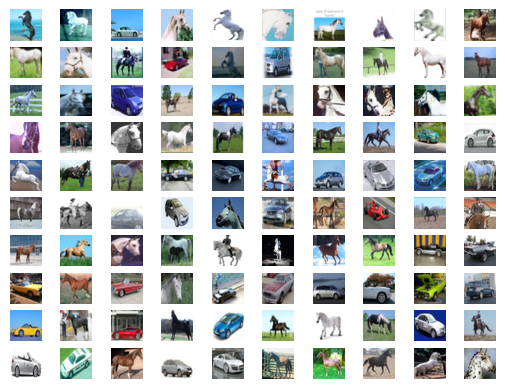

In [ ]:
one_class_conformity = 0
ten_class_conformity = 0
hundred_class_conformity = 0
thousand_class_conformity = 0
num_images_per_axis = 10

for i in range(len(top_n_i_list)):
    if train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.caption_column] == TARGET_CLASS:
        if i<1:
            one_class_conformity += 1
        if i<10:
            ten_class_conformity += 1
        if i<100:
            hundred_class_conformity += 1
        if i<1000:
            thousand_class_conformity += 1
    
one_class_conformity_percentage = (one_class_conformity/1)*100
print(f"Class conformity % (1): {one_class_conformity_percentage}")
ten_class_conformity_percentage = (ten_class_conformity/10)*100
print(f"Class conformity % (10): {ten_class_conformity_percentage}")
hundred_class_conformity_percentage = (hundred_class_conformity/100)*100
print(f"Class conformity % (100): {hundred_class_conformity_percentage}")
thousand_class_conformity_percentage = (thousand_class_conformity/1000)*100
print(f"Class conformity % (1000): {thousand_class_conformity_percentage}")

for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

num_images_per_axis = 10
for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

In [ ]:
MODEL_NAME_CLEAN = trak_config.MODEL_NAME_CLEAN

counter_factual_model_name = f"{TRAK_type}_{MODEL_NAME_CLEAN}_{TARGET_CLASS}_seed_{SEED_TO_PREVIEW}"

cfds.create_counterfactual_config(counter_factual_model_name,top_n_i_list)

True

In [ ]:
print(counter_factual_model_name)

TRAK_sd1-lora_frog_seed_1


In [ ]:
from counter_factuals.counter_factuals_utils import Counter_Factual_Image_Generator

In [ ]:
cfig = Counter_Factual_Image_Generator(
    project_config=project_config,
    counter_factual_model_name=counter_factual_model_name,
    model_type=model_type,
    dataset_type=dataset_type,
)

image = cfig.generate_counter_factual_image(
    seed=SEED_TO_PREVIEW,
    image_class=TARGET_CLASS,
    save_image=True,
    prompts=prompts,
)

plt.axis('off')
plt.imshow(image)

AssertionError: 